In [25]:
import numpy as np
import pandas as pd
import random
import matplotlib.gridspec as gsp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import scipy.stats as stats 
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))  
from scipy.special import gamma, factorial,digamma
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy.special as sp 

import sys
sys.path.append(r'/Users/ys18223/Documents/GitHub/FLAIR_BiocomputeLab')

import flair
import flair.cheat_codes as cc

# Import Data from simulations and inference

In [26]:
df=pd.read_csv('borders4.8.csv')
df.head()

,mu_MLE,sigma_MLE,mu_std,sigma_std,mu_MOM,sigma_MOM,Inference_grade,Score,mu_gt,sigma_gt,mu_diff_mle,mu_diff_MOM,WD_MLE,WD_MOM
0,10.034813,0.614449,0.019290,0.018783,9.962184,0.638806,1.0,0.714976,10.053588,0.628297,0.018775,0.091403,0.029825,0.083019
1,9.610547,0.643111,0.012046,0.013203,9.582377,0.739834,1.0,0.456359,9.609139,0.631807,0.001409,0.026762,0.010427,0.064694
2,6.616488,0.608262,0.010488,0.008823,6.607317,0.733513,1.0,0.000000,6.614673,0.599691,0.001815,0.007356,0.008654,0.099740
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,0.000000,12.588395,0.407422,12.588395,12.588395,12.913471,12.913471
4,9.991885,0.562439,0.019433,0.021928,9.957845,0.634078,1.0,0.709602,10.027675,0.593821,0.035790,0.069830,0.060829,0.040415


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   mu_MLE           100000 non-null  float64
 1   sigma_MLE        100000 non-null  float64
 2   mu_std           100000 non-null  float64
 3   sigma_std        100000 non-null  float64
 4   mu_MOM           100000 non-null  float64
 5   sigma_MOM        100000 non-null  float64
 6   Inference_grade  100000 non-null  float64
 7   Score            100000 non-null  float64
 8   mu_gt            100000 non-null  float64
 9   sigma_gt         100000 non-null  float64
 10  mu_diff_mle      100000 non-null  float64
 11  mu_diff_MOM      100000 non-null  float64
 12  WD_MLE           100000 non-null  float64
 13  WD_MOM           100000 non-null  float64
dtypes: float64(14)
memory usage: 10.7 MB


This data uses the following experimental hyperparameters: 

- Diversity=100000
- Fluorescence_max=10** 4.8
- Bins=8
- Distribution='lognormal'
- N=100000 * 2800
- Ratio_amplification=1
- Budget_reads=1000000* 3000

In [28]:
#Filter out tricky constructs
df=df.loc[df['mu_MLE']!=0]
df=df.loc[df['mu_gt']>1]
df=df.loc[df['Inference_grade']==1]
df=df[df['Score']<0.7]
df=df.dropna()
#Compute visibility score (Given the stringent Fmax, how much of the distribution have we seen for each construct?)
df['Visibility']=df.apply(lambda row: cc.Visibility(row['mu_gt'],row['sigma_gt'],np.log(10**4.8)),axis=1)

In [29]:
Bins=[0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1]
Bins_labels=[0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95]
df['Score_bin'] = pd.cut(df['Visibility'], bins=Bins, labels =Bins_labels)

In [30]:
df.groupby('Score_bin')['WD_MLE'].mean().to_numpy(),df.groupby('Score_bin')['WD_MOM'].mean().to_numpy()

(array([       nan,        nan,        nan,        nan,        nan,
        0.54691892, 0.32362332, 0.08064533, 0.01353397]),
 array([       nan,        nan,        nan,        nan,        nan,
        0.80226432, 0.54813858, 0.14517891, 0.08249402]))

In [31]:
df.groupby('Score_bin')['WD_MLE'].std().to_numpy(),df.groupby('Score_bin')['WD_MOM'].std().to_numpy()

(array([       nan,        nan,        nan,        nan,        nan,
        0.09048128, 0.06111569, 0.04279656, 0.01402551]),
 array([       nan,        nan,        nan,        nan,        nan,
        0.08930858, 0.1082683 , 0.0619173 , 0.03404698]))

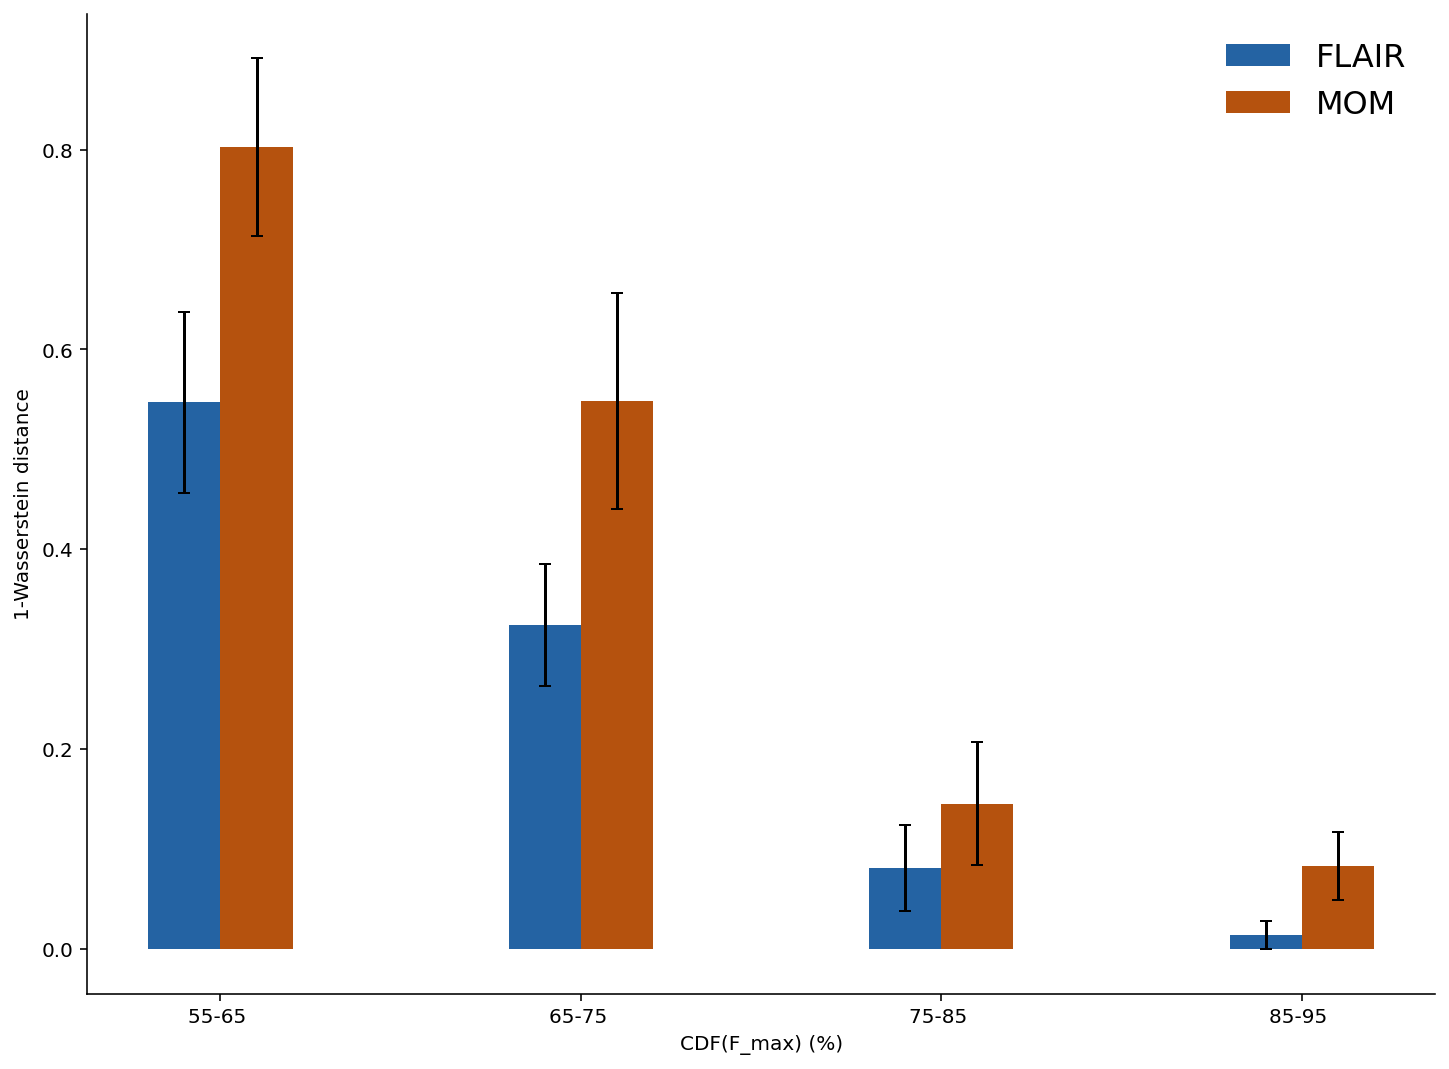

In [35]:
import matplotlib.gridspec as gs
labels =['%s-%s '%(str(i*10+5),str((i+1)*10+5)) for i in range(5,9)] #['%s'%str(i) for i in range(10)]
MAPE_MLE = df.groupby('Score_bin')['WD_MLE'].mean().to_numpy()[5:]
MAPE_MOM = df.groupby('Score_bin')['WD_MOM'].mean().to_numpy()[5:]
STD_MAPE_MLE = df.groupby('Score_bin')['WD_MLE'].std().to_numpy()[5:]
STD_MAPE_MOM = df.groupby('Score_bin')['WD_MOM'].std().to_numpy()[5:]

width = 0.2   # the width of the bars: can also be len(x) sequence

# Create the figure
fig = plt.figure(figsize=(11.7,8.3))
gs =gs.GridSpec(1, 1)
ax = plt.subplot(gs[0])


ax.bar(np.arange(4), MAPE_MLE, width, yerr=STD_MAPE_MLE, label='FLAIR',color='#2463A3',capsize=3)
ax.bar(np.arange(4)+0.2, MAPE_MOM, width, yerr=STD_MAPE_MOM,label='MOM',color='#B5520E',capsize=3)
ax.set_xticks(np.arange(4)+0.1)
ax.set_xticklabels( labels )
ax.set_ylabel('1-Wasserstein distance')
ax.set_xlabel('CDF(F_max) (%)')
#ax.set_title('Breakdown according to visibility')
ax.legend()
sns.despine()
plt.subplots_adjust(hspace=.0 , wspace=.00, left=.15, right=.95, top=.95, bottom=.13)
plt.legend(frameon=False,fontsize=16)